In [11]:
import numpy as np
import h5py
from scipy.io import loadmat
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings

In [12]:
# Sets data location
experiment = 'E338'
runname = '12691'

In [13]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

In [14]:
# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets the calibration value for SYAG in eV/m
SYAG_cal = 64.4e9


### Load dataset

In [15]:
# Loads dataset
dataloc = './' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

In [16]:
# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = 1

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

### Grab XTCAV images on DTOTR2

In [17]:
# Combines the image data into one object
DTOTR2data = None

for a in range(len(stepsAll)):
    raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    # Construct final path assuming ./E338 is your local base folder
    DTOTR2datalocation = './E338/' + match.group(0)

    # Load HDF5 data
    with h5py.File(DTOTR2datalocation, 'r') as f:
        DTOTR2datastep = f['entry']['data']['data'][:].astype(np.float64)
    if a == 0:
        DTOTR2data = DTOTR2datastep
    else:
        DTOTR2data = np.concatenate((DTOTR2data, DTOTR2datastep), axis=0)

In [18]:
DTOTR2data = None

for a in range(len(stepsAll)):
    raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = './E338/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)

    # Transpose to shape: (H, W, N)
    data_transposed = np.transpose(data_raw, (2, 1, 0))

    if DTOTR2data is None:
        DTOTR2data = data_transposed
    else:
        DTOTR2data = np.concatenate((DTOTR2data, data_transposed), axis=2)

In [19]:
# Keeps only the data with a common index
nshots = DTOTR2data.shape[2]


### Rotate the DTOTR2 images so they look like they do on profmon GUIs

In [20]:
DTOTR2data

array([[[ 6., 13., 11., ...,  7.,  6.,  2.],
        [ 5., 16., 11., ...,  7., 15., 14.],
        [ 9.,  6.,  7., ...,  4.,  6., 17.],
        ...,
        [36., 43., 36., ..., 33., 39., 44.],
        [41., 52., 52., ..., 50., 62., 51.],
        [51., 45., 50., ..., 53., 42., 48.]],

       [[ 6.,  0.,  3., ...,  9.,  0., 18.],
        [16.,  2., 14., ..., 11.,  6., 10.],
        [ 4.,  2.,  0., ..., 12.,  3.,  0.],
        ...,
        [30., 21., 30., ..., 30., 22., 40.],
        [39., 34., 38., ..., 29., 39., 23.],
        [38., 42., 35., ..., 38., 40., 38.]],

       [[ 2.,  4.,  1., ..., 12.,  0., 17.],
        [ 7.,  5.,  6., ...,  4., 11.,  9.],
        [10., 16., 20., ..., 13., 23., 20.],
        ...,
        [52., 38., 43., ..., 34., 39., 48.],
        [31., 42., 39., ..., 38., 29., 22.],
        [29., 42., 31., ..., 45., 30., 26.]],

       ...,

       [[ 3.,  1.,  3., ...,  0.,  0., 14.],
        [ 2.,  0.,  0., ...,  9.,  7.,  4.],
        [ 2.,  0.,  0., ...,  0.,  1.,  0.

In [21]:
xtcavImages = DTOTR2data - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)

In [22]:
xtcavImages

array([[[  4.,  11.,   9., ...,   5.,   4.,   0.],
        [ -5.,   6.,   1., ...,  -3.,   5.,   4.],
        [  9.,   6.,   7., ...,   4.,   6.,  17.],
        ...,
        [ -5.,   2.,  -5., ...,  -8.,  -2.,   3.],
        [-11.,   0.,   0., ...,  -2.,  10.,  -1.],
        [-19., -25., -20., ..., -17., -28., -22.]],

       [[ -4., -10.,  -7., ...,  -1., -10.,   8.],
        [ 10.,  -4.,   8., ...,   5.,   0.,   4.],
        [ -5.,  -7.,  -9., ...,   3.,  -6.,  -9.],
        ...,
        [ -4., -13.,  -4., ...,  -4., -12.,   6.],
        [  2.,  -3.,   1., ...,  -8.,   2., -14.],
        [  5.,   9.,   2., ...,   5.,   7.,   5.]],

       [[  0.,   2.,  -1., ...,  10.,  -2.,  15.],
        [ -9., -11., -10., ..., -12.,  -5.,  -7.],
        [  5.,  11.,  15., ...,   8.,  18.,  15.],
        ...,
        [ 15.,   1.,   6., ...,  -3.,   2.,  11.],
        [ -6.,   5.,   2., ...,   1.,  -8., -15.],
        [  2.,  15.,   4., ...,  18.,   3.,  -1.]],

       ...,

       [[ -5.,  -7.,  -5

### Get the XTCAV phase on each shot (important if toggler is on)

In [23]:
def matstruct_to_dict(obj):
    """
    Recursively convert MATLAB structs (loaded via scipy.io.loadmat) to Python dictionaries.
    """
    if isinstance(obj, scipy.io.matlab.mio5_params.mat_struct):
        result = {}
        for fieldname in obj._fieldnames:
            result[fieldname] = matstruct_to_dict(getattr(obj, fieldname))
        return result
    elif isinstance(obj, np.ndarray):
        if obj.dtype == 'object':
            return [matstruct_to_dict(o) for o in obj]
        else:
            return obj
    else:
        return obj

In [24]:
def extractDAQBSAScalars(data_struct):
    data_struct = matstruct_to_dict(data_struct)
    dataScalars = data_struct['scalars']
    idx = dataScalars['common_index'].astype(int).flatten()

    fNames = list(dataScalars.keys())
    isBSA = [name for name in fNames if name.startswith('BSA_List_')]

    bsaScalarData = []
    bsaVarPVs = []

    for bsaName in isBSA:
        bsaList = dataScalars[bsaName]
        varNames = list(bsaList.keys())
        bsaListData = []

        for varName in varNames:
            varData = np.array(bsaList[varName]).squeeze()
            if varData.size == 0:
                continue
            varData = varData[idx]  # apply common index
            varData = np.nan_to_num(varData)  # replace NaN with 0
            bsaListData.append(varData)

        # Add to output arrays
        bsaVarPVs.extend([vn for vn in varNames if bsaList[vn].size != 0])
        if bsaListData:
            bsaScalarData.extend(bsaListData)

    bsaScalarData = np.array(bsaScalarData)
    return bsaScalarData, bsaVarPVs


In [25]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_66421/2963694151.py:5: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(obj, scipy.io.matlab.mio5_params.mat_struct):


In [26]:
ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

In [27]:
xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

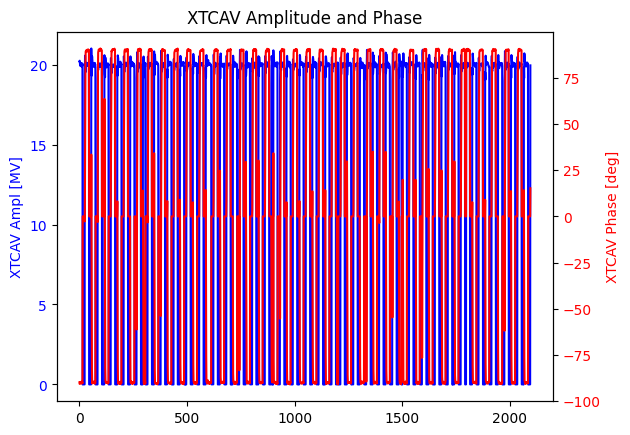

In [28]:
fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('XTCAV Amplitude and Phase')
plt.show()

### Plot sample images of the beam with tcav at +90 deg, 0 and -90 deg

In [29]:

def cropProfmonImg(img, xrange, yrange, plot_flag=False):
    """
    Crop a 2D image around the peak of horizontal and vertical projections,
    returning a region of shape (2*yrange, 2*xrange), with padding if needed.

    Args:
        img (2D np.ndarray): Input image.
        xrange (int): Half-width in x-direction.
        yrange (int): Half-height in y-direction.
        plot_flag (bool): If True, show plots.

    Returns:
        cropped_img (2D np.ndarray): Cropped image (always 2*yrange by 2*xrange).
        error_flag (int): 0 if successful, 1 if fallback used.
    """
    img = img.astype(float)
    img_h, img_w = img.shape

    # Use max projections to find "COM"
    x_com = int(np.argmax(np.sum(img, axis=0)))
    y_com = int(np.argmax(np.sum(img, axis=1)))

    # Desired window size
    x_start = x_com - xrange
    x_end   = x_com + xrange
    y_start = y_com - yrange
    y_end   = y_com + yrange

    # Compute required padding if indices go out of bounds
    pad_left   = max(0, -x_start)
    pad_right  = max(0, x_end - img_w)
    pad_top    = max(0, -y_start)
    pad_bottom = max(0, y_end - img_h)

    # Pad image as needed
    if any([pad_left, pad_right, pad_top, pad_bottom]):
        img = np.pad(img, 
                     ((pad_top, pad_bottom), (pad_left, pad_right)), 
                     mode='constant', constant_values=0)
        error_flag = 1  # Fallback was needed
    else:
        error_flag = 0

    # Recalculate indices after padding
    x_start += pad_left
    x_end   += pad_left
    y_start += pad_top
    y_end   += pad_top

    # Crop
    cropped_img = img[y_start:y_end, x_start:x_end]

    # Sanity check
    if cropped_img.shape != (2*yrange, 2*xrange):
        warnings.warn(f"Cropped image shape mismatch: got {cropped_img.shape}")
        error_flag = 1

    if plot_flag:
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        axs[0].imshow(img, cmap='viridis', aspect='auto')
        axs[0].set_title("Original / Padded Image")
        axs[1].imshow(cropped_img, cmap='viridis', aspect='auto')
        axs[1].set_title("Cropped Image")
        plt.tight_layout()
        plt.show()

    return cropped_img, error_flag


In [30]:
np.where(xtcavPhase == 0)[0][0]

np.int64(15)

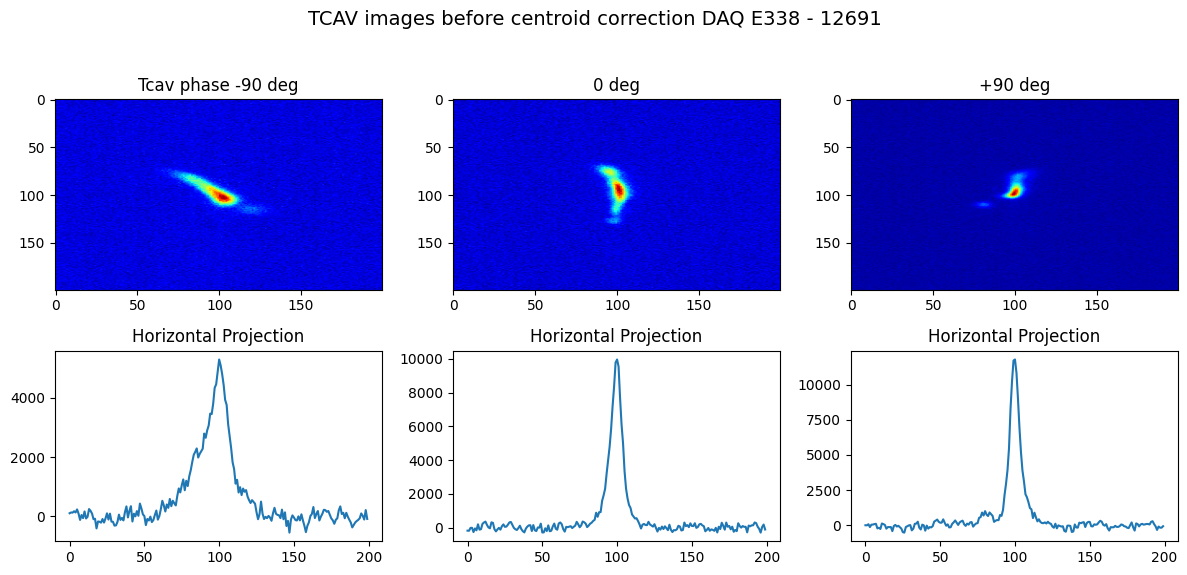

In [31]:
# Find the first shot where tcav is at -90, 0 and +90 deg
near_minus_90_idx = np.where((xtcavPhase >= -90.55) & (xtcavPhase <= -89.55))[0][0]
near_plus_90_idx = np.where((xtcavPhase >= 89.55) & (xtcavPhase <= 90.55))[0][0]
zero_idx = np.where(xtcavPhase == 0)[0][1]

sample_image_indices = [near_minus_90_idx, zero_idx, near_plus_90_idx]
plot_titles = ['Tcav phase -90 deg', '0 deg', '+90 deg']


# Define the x and yrange for cropping the image; Need to automate this
# figure;imagesc(sampleImage)

xrange = 100
yrange = xrange

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images before centroid correction DAQ {experiment} - {runname}', fontsize=14)

for i, idx in enumerate(sample_image_indices):
    if idx is None:
        continue

    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)
    horz_proj = np.sum(sample_image_cropped, axis=0)

    axs[0, i].imshow(sample_image_cropped, cmap='jet', aspect='auto')
    axs[0, i].set_title(plot_titles[i])

    axs[1, i].plot(horz_proj)
    axs[1, i].set_title("Horizontal Projection")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate centroid correction

In [32]:
from scipy.ndimage import median_filter, gaussian_filter

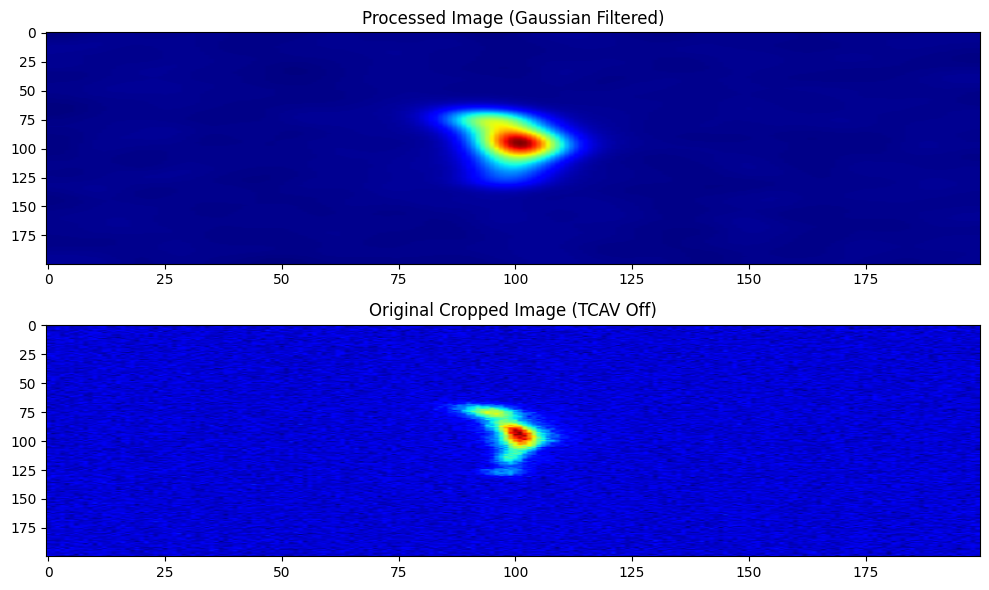

In [33]:
sample_image_tcav_off = xtcavImages[:, :, sample_image_indices[1]]
sample_image_tcav_off, _ = cropProfmonImg(sample_image_tcav_off, xrange, yrange, plot_flag=False)

img = median_filter(sample_image_tcav_off, size=3)
sigma = 5
processed_image = gaussian_filter(img, sigma=sigma)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.imshow(processed_image, cmap='jet', aspect='auto')
plt.title("Processed Image (Gaussian Filtered)")

plt.subplot(2, 1, 2)
plt.imshow(sample_image_tcav_off, cmap='jet', aspect='auto')
plt.title("Original Cropped Image (TCAV Off)")

plt.tight_layout()
plt.show()


In [34]:
def segment_centroids_and_com(image, nrows, return_com=True):
    """
    Segments the image row-wise and computes the center of mass for each row.

    Parameters:
    - image: 2D numpy array (cropped and processed XTCAV image)
    - nrows: int, number of rows (typically image.shape[0])
    - return_com: if True, returns center of mass positions; else returns only row indices

    Returns:
    - centroid_indices: numpy array of row indices (0 to nrows-1)
    - centers_of_mass: numpy array of COM along the horizontal axis for each row
    """

    height, width = image.shape
    centroid_indices = np.arange(nrows)
    centers_of_mass = np.zeros(nrows)

    for i in range(nrows):
        row = image[i, :]
        total_mass = np.sum(row)
        if total_mass > 0:
            x_coords = np.arange(width)
            com = np.sum(row * x_coords) / total_mass
        else:
            com = np.nan
        centers_of_mass[i] = com

    if return_com:
        return centroid_indices, centers_of_mass
    else:
        return centroid_indices

### Apply centroid correction to images and replot

In [35]:
sample_image_indices

[np.int64(0), np.int64(16), np.int64(31)]

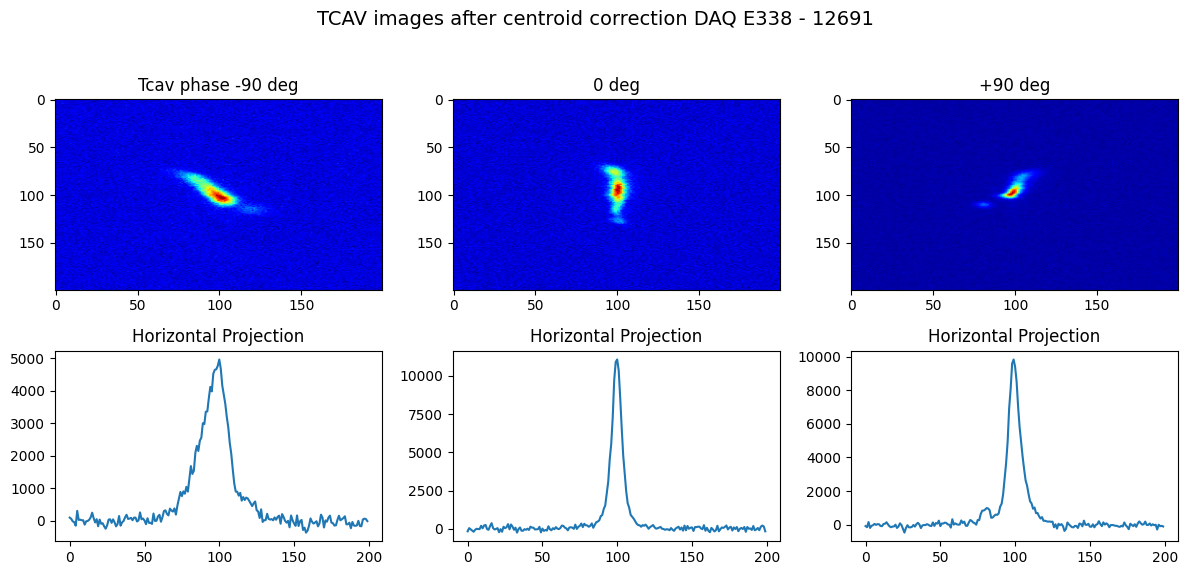

In [36]:
Nrows = np.array(sample_image_tcav_off).shape[0]
[centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images after centroid correction DAQ {experiment} - {runname}', fontsize=14)

for i, idx in enumerate(sample_image_indices):
    if idx is None:
        continue

    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)


    centroid_corrections = np.round((centers_of_mass/np.abs(centers_of_mass))*np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    horz_proj = np.sum(sample_image_shifted, axis=0)

    axs[0, i].imshow(sample_image_shifted, cmap='jet', aspect='auto')
    axs[0, i].set_title(plot_titles[i])

    axs[1, i].plot(horz_proj)
    axs[1, i].set_title("Horizontal Projection")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate the current profile normalizing the integral to the charge

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_66421/1324045990.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


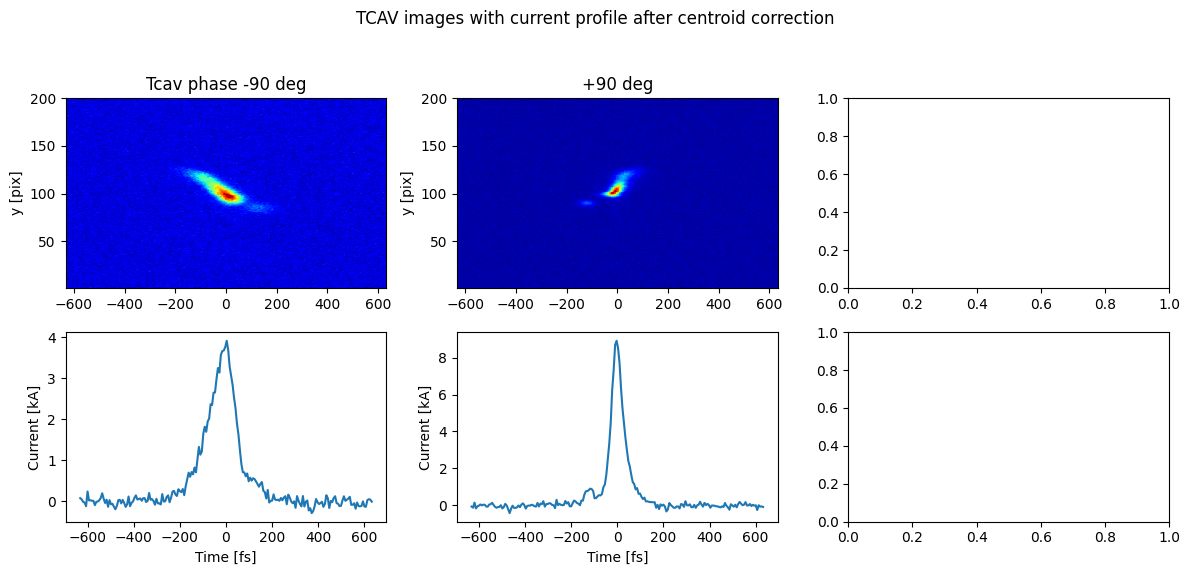

In [39]:
isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images with current profile after centroid correction')

for i, (ij, idx) in enumerate([(i, idx) for i, idx in enumerate(sample_image_indices) if i != 1]):
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    # Centroid correction
    centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -int(centroid_corrections[row])
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Current profile
    streakedProfile = np.sum(sample_image_shifted, axis=0)
    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar -= np.median(tvar)
    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
    currentProfile = streakedProfile * prefactor

    # Plot image
    axs[0, i].imshow(sample_image_shifted, cmap='jet', aspect='auto',
                     extent=[tvar[0]*1e15, tvar[-1]*1e15, 1, sample_image_shifted.shape[0]])
    axs[0, i].set_ylabel('y [pix]')
    axs[0, i].set_title(plot_titles[ij])

    # Plot projection
    axs[1, i].plot(tvar * 1e15, currentProfile * 1e-3)
    axs[1, i].set_xlabel('Time [fs]')
    axs[1, i].set_ylabel('Current [kA]')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Loop thru all +90 and -90 deg shots and calculate the current profile

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_54295/1088279799.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_54295/1088279799.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


NameError: name 'plotTitles' is not defined

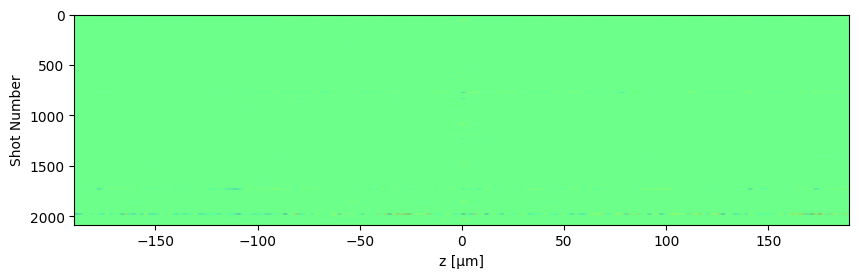

In [ ]:
# Note here i'm assuming the centroid correction can be taken from a single 
#    tcav off image. A better treatment would find the nearest tcav off image
#   in the dataset and use that to apply the centroid correction on each shot

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]

currentProfile_minus_90 = []
currentProfile_plus_90 = []

# Process -90 degree shots
for ij in range(len(minus_90_idx)):
    idx = minus_90_idx[ij]
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Calculate the current profile from the streaked projection
    streakedProfile = np.sum(sample_image_cropped, axis=0)

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_minus_90.append(currentProfile)

# Process +90 degree shots
for ij in range(len(plus_90_idx)):
    idx = minus_90_idx[ij]
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Calculate the current profile from the streaked projection
    streakedProfile = np.sum(sample_image_cropped, axis=0)

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_plus_90.append(currentProfile)

# Convert lists to arrays for plotting
currentProfile_minus_90 = np.array(currentProfile_minus_90)
currentProfile_plus_90 = np.array(currentProfile_plus_90)

# Plot
plt.figure(figsize=(10, 6))

# Subplot for -90°
plt.subplot(2, 1, 1)
extent_x = tvar * 3e8 * 1e6  # Convert to microns
plt.imshow(currentProfile_minus_90, aspect='auto', cmap='jet',
           extent=[extent_x[0], extent_x[-1], minus_90_idx[-1], minus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plotTitles[0])
plt.colorbar(label='I [kA]')

# Subplot for +90°
plt.subplot(2, 1, 2)
plt.imshow(currentProfile_plus_90, aspect='auto', cmap='jet',
           extent=[extent_x[0], extent_x[-1], plus_90_idx[-1], plus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plotTitles[2])
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()